<a href="https://colab.research.google.com/github/Nogren99/EMNIST---FEEDFORWARD-NEURAL-NETWORKS/blob/main/EMNIST_FEEDFORWARD_NEURAL_NETWORKS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install extra-keras-datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Bloque de imports:

import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from extra_keras_datasets import emnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

plt.rcParams['figure.figsize'] = [3, 3]

In [2]:
file_path_test = '/content/drive/MyDrive/2024/DATASET/emnist-letters-test.csv'
file_path_train = '/content/drive/MyDrive/2024/DATASET/emnist-letters-train.csv'

In [39]:

#divide los datos en conjuntos de entrenamiento y prueba.
def cargar_dataset(file_path_train, file_path_test):
	# Cargar CSV con pandas
	train_df = pd.read_csv(file_path_train, header=None)
	test_df = pd.read_csv(file_path_test, header=None)

	train_df =train_df[train_df.iloc[:, 0]<=19]
	test_df =test_df[test_df.iloc[:, 0]<=19]

	# Separar etiquetas y datos de imágenes
	trainY = train_df.iloc[:, 0].values  # La primera columna son las etiquetas
	trainX = train_df.iloc[:, 1:].values  # El resto son los píxeles de la imagen
	testY = test_df.iloc[:, 0].values
	testX = test_df.iloc[:, 1:].values

	# Reestructurar las imágenes a (cantidad, 28, 28, 1)
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))

	# Clasificación en one-hot encoding (26 clases para letras)
	trainY = to_categorical(trainY - 1, num_classes=26)
	testY = to_categorical(testY - 1, num_classes=26)
	return trainX, trainY, testX, testY

	print(f'Train shapes: {trainX.shape}, {trainY.shape}')
	print(f'Test shapes: {testX.shape}, {testY.shape}')


# Normalización de tonos de pixel
def prep_pixels(train, test):
	# Transformar integers en floats
	#Convierte los valores de los píxeles, que originalmente son enteros entre 0 y 255, a números de punto flotante (float32).
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# Normalizar 0-1
	#Normaliza los valores de los píxeles dividiéndolos por 255, para que queden en el rango de 0 a 1.
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# Devolver normalizado
	return train_norm, test_norm

# Graficar ua letra
#Esta función se usa para visualizar una imagen de los conjuntos de entrenamiento o prueba.
def graficar_uno(valor, conjunto, prediccion=None):
	#fig = plt.figure
	#Muestra la imagen en escala de grises (cmap='gray_r'), utilizando plt.imshow(), donde conjunto[valor] selecciona la imagen a graficar.
	#El parámetro valor es el índice de la imagen que se desea mostrar.
	plt.imshow(conjunto[valor].reshape(28, 28), cmap='gray_r')
  #Verifica si la imagen proviene del conjunto de entrenamiento (trainX) o de prueba (testX).
	#Si es de entrenamiento, muestra la etiqueta real del dígito en el eje X.
	#Si es de prueba, también muestra la etiqueta real en el eje X.
	if np.array_equiv(conjunto, trainX):
			plt.xlabel('Label train: {}'.format(np.argmax(trainY[valor])))
	if np.array_equiv(conjunto, testX):
			plt.xlabel('Label test: {}'.format(np.argmax(testY[valor])))
	if prediccion is not None:
			plt.ylabel('Predicho: ' + str(prediccion))
	return plt.show()

In [6]:
#Esta función permite graficar las matrices de confusión de manera agradable a la vista
# Esta función recibe los siguientes parámetros:

# y_true: Las etiquetas verdaderas.
# y_pred: Las etiquetas predichas por el modelo.
# classes: Una lista o arreglo con los nombres o etiquetas de las clases (por defecto, un arreglo de 0 a 9 para un problema con 10 clases).
# normalize: Si es True, normaliza la matriz de confusión dividiendo cada valor por el total de su fila (esto convierte los valores en proporciones). Por defecto es False, lo que significa que los valores serán cantidades enteras.
# title: El título del gráfico (opcional). Si no se proporciona, se establece un título por defecto.
# cmap: El mapa de colores para el gráfico (por defecto es Purples).
def plot_confusion_matrix(y_true, y_pred, classes=np.arange(10),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Purples):
    if not title:
        if normalize:
            title = 'Matriz de confusión normalizada'
        else:
            title = 'Matriz de confusión sin normalizar'
    # Compute confusion matrix
    #Utiliza confusion_matrix() para calcular la matriz de confusión a partir de las etiquetas verdaderas (y_true) y predichas (y_pred).
    cm = confusion_matrix(y_true, y_pred)
    #Si se elige la normalización (normalize=True), se transforma la matriz de confusión en valores proporcionales dividiendo cada valor por el total de su fila.
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Matriz de confusión normalizada')
    else:
        print('Matriz de confusión sin normalizar')
    print(cm)
    #Crea un objeto gráfico (fig) y un eje (ax) con un tamaño de 10x7.
    fig, ax = plt.subplots(figsize=(10, 7))
    #Muestra la matriz de confusión utilizando imshow(), aplicando la colormap Purples por defecto
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    #Configura los ticks de los ejes x e y para que correspondan a las clases
    #(es decir, los valores de las etiquetas). Los ejes también reciben etiquetas:
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Cifra predicha',
           xlabel='Cifra verdadera')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    #Establece el formato de los valores mostrados dentro de la matriz.
    #Si la matriz está normalizada, usa dos decimales (.2f); de lo contrario, muestra enteros (d).
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #Recorre las celdas de la matriz de confusión y coloca anotaciones con los valores correspondientes.
    #Los valores en celdas con números altos (mayores que la mitad del valor máximo de la matriz)
    #se mostrarán en color blanco, y en color negro para los valores bajos, para asegurar que el texto sea legible.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=3)

In [7]:
# Evaluador SIMPLE
#Este conjunto de funciones proporciona una forma de entrenar y evaluar modelos de aprendizaje profundo
#utilizando tanto una estrategia de evaluación simple como validación cruzada

#Esta función entrena un modelo de manera directa sin dividir los datos en k-folds.
# dataX y dataY: Los datos de entrada (imágenes) y las etiquetas.
# modelo: Una función que devuelve un modelo (probablemente una red neuronal).
# estadoaleatorio: (Opcional) Controla la semilla para reproducibilidad (aunque no se usa dentro de esta función).
# epocas: El número de épocas para entrenar el modelo.
def evaluar_modelo_simple(dataX,dataY,modelo,estadoaleatorio=1,epocas=10):
	scores, histories= [], []
	model = modelo()
  #Entrena el modelo con los datos de entrenamiento (trainX, trainY) por el número de épocas especificado (epocas)
  #y evalúa su rendimiento con los datos de prueba (testX, testY).
  #Utiliza un tamaño de batch de 32 y muestra detalles del entrenamiento (verbose=1)
	history = model.fit(trainX, trainY, epochs=epocas, batch_size=32, validation_data=(testX, testY), verbose=1)
  #Evalúa el modelo con los datos de prueba y almacena la precisión (accuracy) en la variable acc.
	_, acc = model.evaluate(testX, testY, verbose=1)
  #Imprime la precisión del modelo.
	print('> %.3f' % (acc * 100.0))
	scores.append(acc)
	histories.append(history)
	return scores, histories, model

# Evaluación con k-fold cross-validation
#Esta función realiza una evaluación más robusta usando validación cruzada k-fold.
#n_folds: Número de particiones (folds) para la validación cruzada (por defecto, 5).
#estadoaleatorio: Semilla para reproducibilidad (para el shuffle de los folds).
def evaluar_modelo_kfold(dataX, dataY, modelo, n_folds=5, estadoaleatorio=1):
	scores, histories = list(), list()
	# preparar los k-fold
  #Define un objeto KFold que dividirá los datos en n_folds particiones de manera aleatoria,
  #respetando el estado aleatorio (random_state=estadoaleatorio).
	kfold = KFold(n_folds, shuffle=True, random_state=estadoaleatorio)
	# Enumerar las divisiones
  # Itera sobre las divisiones generadas por kfold.split(dataX),
  #donde se obtienen los índices de las filas de entrenamiento (train_ix) y prueba (test_ix).
	for train_ix, test_ix in kfold.split(dataX):
		# definir model
		model = modelo()
		# elegir filas para train y validation
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fitear modelo
    #Entrena el modelo con los datos seleccionados (trainX, trainY) durante 10 épocas.
    #Usa los datos de prueba (testX, testY) para validación durante el entrenamiento.
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluar modelo
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# guardar puntajes
    #Almacena la precisión y el historial de entrenamiento de cada fold en las listas scores y histories.
		scores.append(acc)
		histories.append(history)
	return scores, histories, model



# Graficar diagnósticos
#Esta función grafica los resultados del entrenamiento,
#específicamente la pérdida (loss) y la precisión (accuracy) para cada fold o modelo entrenado.
def diagnosticos(histories):
	for i in range(len(histories)):
		# graficar loss
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# graficar accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	plt.show()

In [40]:
# Cargar dataset
trainX, trainY, testX, testY = cargar_dataset(file_path_train, file_path_test)

# Normalizar datos
trainX, testX = prep_pixels(trainX, testX)

In [41]:
print(f'Train shapes: {trainX.shape}, {trainY.shape}')
print(f'Test shapes: {testX.shape}, {testY.shape}')


Train shapes: (64783, 28, 28, 1), (64783, 26)
Test shapes: (14800, 28, 28, 1), (14800, 26)


In [10]:
#toma una red neuronal ya entrenada y un conjunto de datos (por defecto testX),
#y devuelve un diccionario con la cantidad de predicciones hechas para cada clase.

def predecirparaunalista(redneuronalentrenada,conjunto=testX):
    #puntajes contiene las salidas del modelo, que son probabilidades o puntuaciones para cada clase de cada imagen.
    #Por ejemplo, para una red que clasifica 10 clases,
    #cada elemento de puntajes será un vector de 10 valores (uno por cada clase).
    puntajes = redneuronalentrenada.predict(conjunto)
    #Se crea un array llamado prediccion de ceros, con el mismo tamaño que el conjunto de datos
     #(es decir, habrá un valor de predicción para cada imagen). Este array almacenará las clases predichas.
    prediccion =np.zeros(len(conjunto),dtype=int)
    #Para cada imagen del conjunto (desde el índice 1, lo que puede ser un error ya que debería empezar desde 0 para incluir todas las imágenes),
    #el valor de np.argmax(puntajes[x]) selecciona la clase con la probabilidad más alta del vector puntajes[x].
    for x in range(1,len(conjunto)):
        prediccion[x] = np.argmax(puntajes[x])

    #devuelve dos arrays:
    # unique: Las clases únicas predichas.
    # counts: La cantidad de veces que cada clase fue predicha.
    # dict(zip(unique, counts)) convierte estos dos arrays en un diccionario, donde las claves son las clases predichas y los valores son el número de veces que esa clase fue predicha.
    unique, counts = np.unique(prediccion,return_counts=True)
    return dict(zip(unique,counts))

In [56]:
#genera una matriz de confusión a partir de las predicciones realizadas por una red neuronal entrenada.
#La matriz de confusión compara las predicciones del modelo con las etiquetas reales,
#y puede ser utilizada tanto en su forma sin normalizar (valores absolutos) como en una versión normalizada (valores relativos).
# redneuronalentrenada: La red neuronal que ya fue entrenada.
# conjunto: El conjunto de datos sobre los cuales hacer las predicciones (por defecto es testX, el conjunto de prueba).
# targetsonehot: Las etiquetas verdaderas de las imágenes en formato one-hot (por defecto es testY).
# normalizar: Un parámetro booleano que indica si la matriz de confusión debe estar normalizada o no (por defecto es False).
# def matrizdeconfusion(redneuronalentrenada,conjunto=testX, targetsonehot=testY, normalizar=False):
#     puntajes = redneuronalentrenada.predict(conjunto)
#     prediccion =np.zeros(len(conjunto),dtype=int)
#     for x in range(1,len(conjunto)):
#         prediccion[x] = np.argmax(puntajes[x])
#     plot_confusion_matrix(prediccion, np.argmax(targetsonehot, axis= 1), normalize=normalizar, title= "Matriz de confusión")
#     plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
def matrizdeconfusion(redneuronalentrenada, conjunto=testX, targetsonehot=testY, normalizar=False):
    # Generar predicciones
    puntajes = redneuronalentrenada.predict(conjunto)
    prediccion = np.argmax(puntajes, axis=1)

    # Obtener las verdaderas etiquetas
    etiquetas_reales = np.argmax(targetsonehot, axis=1)

    # Generar la matriz de confusión
    matriz_confusion = confusion_matrix(etiquetas_reales, prediccion, normalize='true' if normalizar else None)

    # Etiquetas del eje
    etiquetas = [chr(i) for i in range(65, 84)]  # Letras A-Z

    # Graficar la matriz de confusión
    plt.figure(figsize=(16, 16))
    sns.heatmap(matriz_confusion, annot=True, fmt='.2f', cmap='Blues', xticklabels=etiquetas, yticklabels=etiquetas)
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.show()

In [12]:
#Esta función encuentra los índices en los que dos listas no son iguales
# Se compara cada elemento en las mismas posiciones de las dos listas.
# Si los elementos en una posición específica son diferentes, el índice de esa posición se guarda en la lista non_equal_indices.
def find_non_equal_indices(list1, list2):
    non_equal_indices = []
    for i in range(min(len(list1), len(list2))):
        if list1[i] != list2[i]:
            non_equal_indices.append(i)
    return non_equal_indices

def listarerrores(adivinado,objetivo=testY):
    errores = find_non_equal_indices(adivinado,np.argmax(objetivo, axis = 1))
    return errores

In [43]:
print ("Tamaño de conjunto de entrenamiento: "+str(len(trainX)) + "\n"+"Tamaño de conjunto de test:          "+str(len(testX)))

Tamaño de conjunto de entrenamiento: 64783
Tamaño de conjunto de test:          14800


In [14]:
# plt.rcParams: Es un diccionario que contiene configuraciones globales de Matplotlib. Estas configuraciones pueden ajustarse para personalizar el estilo y el comportamiento de los gráficos.

# 'figure.figsize': Esta clave específica define el tamaño de las figuras en pulgadas. Es un array que toma dos valores:

# El primer valor (3 en este caso) es el ancho de la figura en pulgadas.
# El segundo valor (también 3 en este caso) es la altura de la figura en pulgadas.


plt.rcParams['figure.figsize'] = [3, 3]

In [ ]:
5 imágenes aleatorias del conjunto de entrenamiento

graficar_uno(1, trainX)
graficar_uno(145, trainX)
graficar_uno(134, trainX)
graficar_uno(31, trainX)
graficar_uno(9166, trainX)

APLICACION DE REDES NEURONALES

===== **DESCENSO POR GRADIENTE** =====

In [73]:
def red_simple():
	model = Sequential()
	model.add(Flatten())
	model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
	model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
	model.add(Dense(26, activation='softmax'))
	opt = keras.optimizers.SGD(learning_rate=0.01) # Descenso por gradiente.
	model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [74]:
# scores: Una lista que contiene los puntajes de precisión obtenidos durante la evaluación del modelo.
# histories: Una lista que contiene los historiales de entrenamiento del modelo, incluyendo la evolución de la pérdida (loss) y la precisión (accuracy) en el conjunto de entrenamiento y validación.
# entrenado: El modelo entrenado, que puede ser usado para hacer predicciones o para evaluaciones adicionales.

scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple)

Epoch 1/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.4700 - loss: 1.8872 - val_accuracy: 0.7231 - val_loss: 0.9228
Epoch 2/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7342 - loss: 0.8688 - val_accuracy: 0.7651 - val_loss: 0.7662
Epoch 3/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7800 - loss: 0.7193 - val_accuracy: 0.7943 - val_loss: 0.6609
Epoch 4/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8106 - loss: 0.6187 - val_accuracy: 0.8188 - val_loss: 0.5937
Epoch 5/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8345 - loss: 0.5382 - val_accuracy: 0.8344 - val_loss: 0.5306
Epoch 6/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8462 - loss: 0.4904 - val_accuracy: 0.8478 - val_loss: 0.4888
Epoch 7/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8591 - loss: 0.4451 - val_accuracy: 0.8514 - val_loss: 0.4664
Epoch 8/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8715 - loss: 0.4

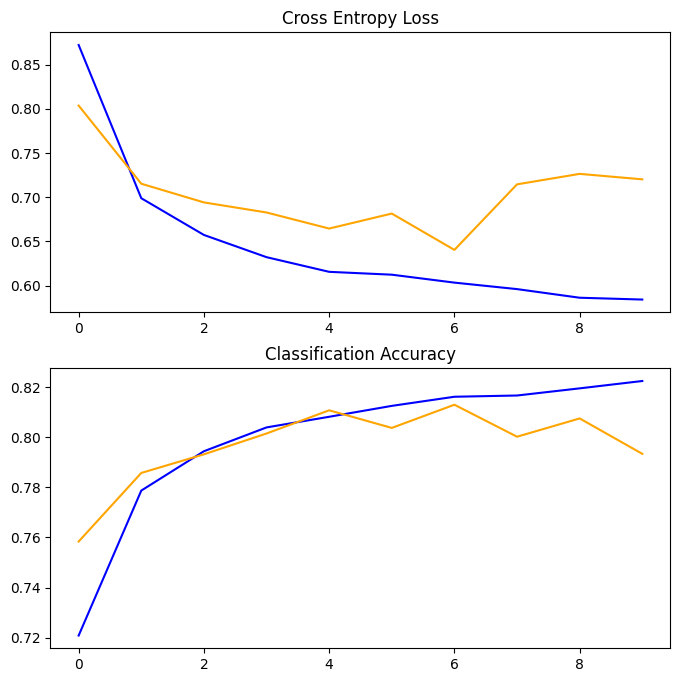

In [80]:
plt.rcParams['figure.figsize'] = [8, 8]
diagnosticos(histories)

====== **ADAM** ======

In [78]:
def red_simple2():
	model = Sequential()
	model.add(Flatten())
	model.add(Dense(52, activation="relu")) # Capas ocultas con RELU
	model.add(Dense(52, activation="relu")) # Capas ocultas con RELU
	model.add(Dense(26, activation='softmax'))
	opt = keras.optimizers.Adam(learning_rate=0.01) # ADAM.
	model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

Epoch 1/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.6538 - loss: 1.0837 - val_accuracy: 0.7584 - val_loss: 0.8037
Epoch 2/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.7740 - loss: 0.7102 - val_accuracy: 0.7857 - val_loss: 0.7153
Epoch 3/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7948 - loss: 0.6488 - val_accuracy: 0.7932 - val_loss: 0.6942
Epoch 4/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8065 - loss: 0.6209 - val_accuracy: 0.8015 - val_loss: 0.6827
Epoch 5/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8089 - loss: 0.6052 - val_accuracy: 0.8107 - val_loss: 0.6646
Epoch 6/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8157 - loss: 0.6023 - val_accuracy: 0.8037 - val_loss: 0.6815
Epoch 7/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8172 - loss: 0.5981 - val_accuracy: 0.8130 - val_loss: 0.6404
Epoch 8/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8204 - loss: 0.5792

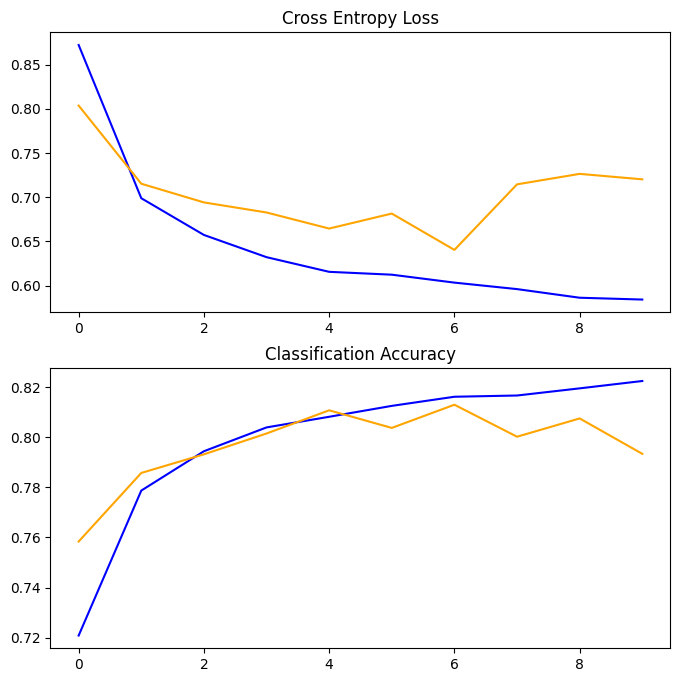

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


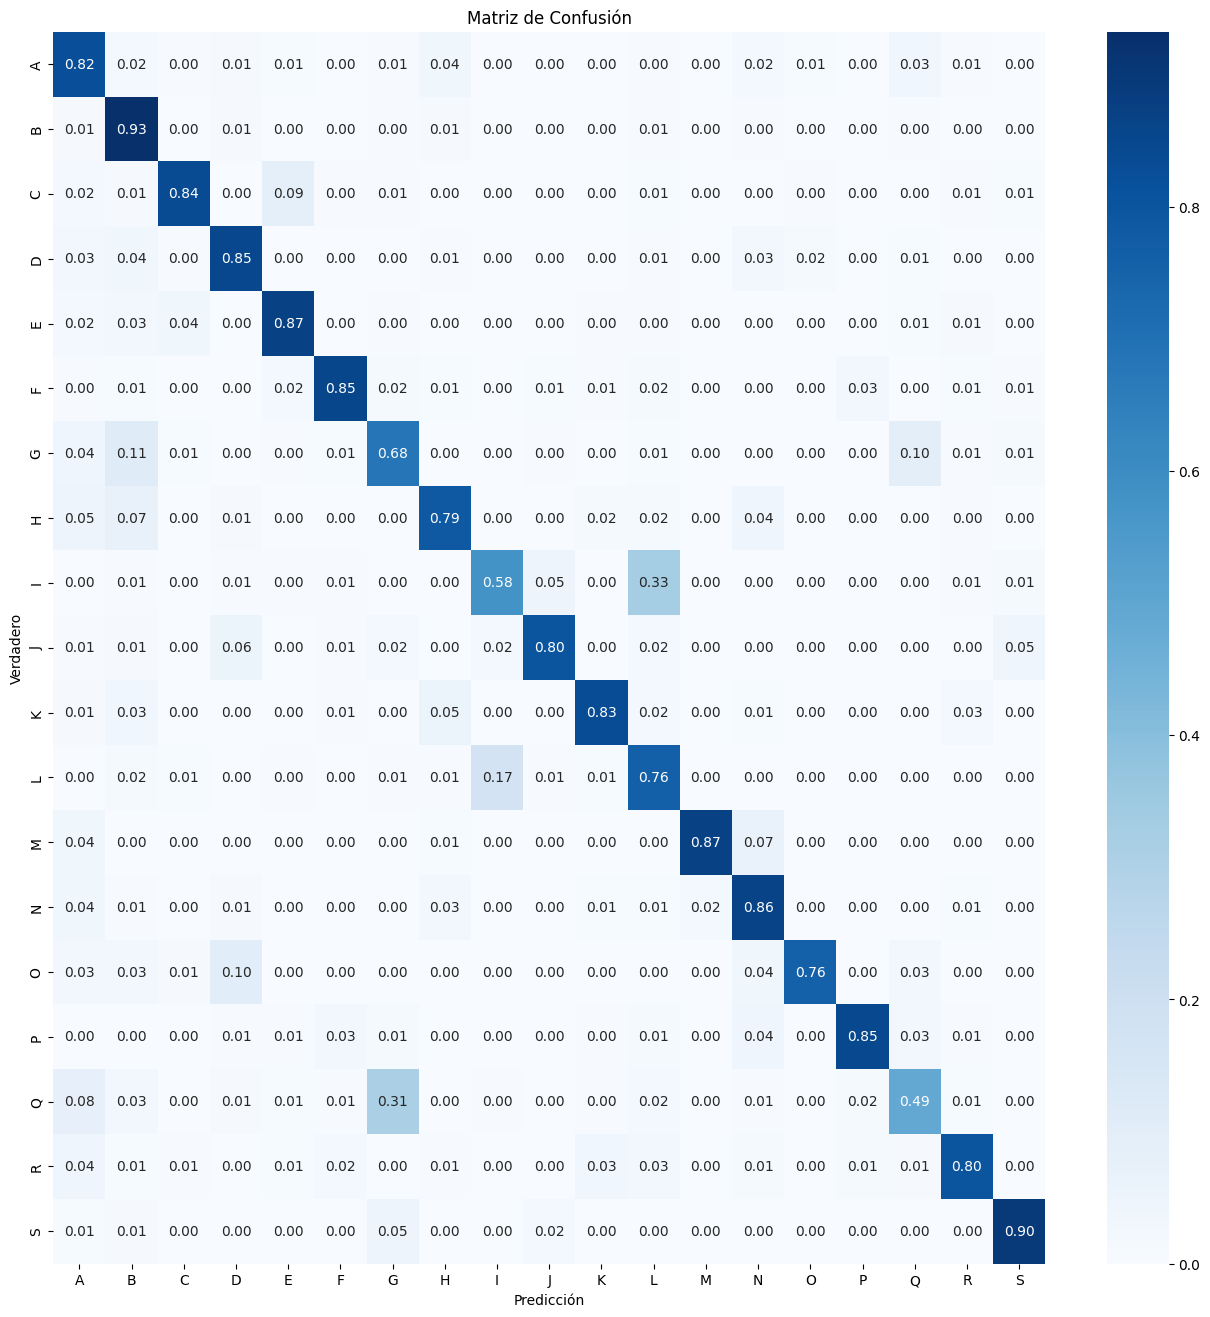

In [79]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple2,epocas=10)
diagnosticos(histories)
matrizdeconfusion(entrenado,normalizar=True)

====== **RMSprop** ======

In [82]:
def red_simple3():
	model = Sequential()
	model.add(Flatten())
	model.add(Dense(52, activation="relu")) # Capas ocultas con RELU
	model.add(Dense(52, activation="relu")) # Capas ocultas con RELU
	model.add(Dense(26, activation='softmax'))
	opt = keras.optimizers.RMSprop(learning_rate=0.01) # RMSprop
	model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

Epoch 1/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6215 - loss: 1.2154 - val_accuracy: 0.7344 - val_loss: 0.9377
Epoch 2/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7294 - loss: 0.9673 - val_accuracy: 0.7045 - val_loss: 1.2319
Epoch 3/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7183 - loss: 1.0845 - val_accuracy: 0.6547 - val_loss: 1.2184
Epoch 4/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6991 - loss: 1.2053 - val_accuracy: 0.7139 - val_loss: 1.6150
Epoch 5/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6733 - loss: 1.3507 - val_accuracy: 0.6809 - val_loss: 1.6313
Epoch 6/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6561 - loss: 1.4459 - val_accuracy: 0.6344 - val_loss: 1.4843
Epoch 7/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6124 - loss: 1.6041 - val_accuracy: 0.6022 - val_loss: 1.9865
Epoch 8/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5863 - loss: 1.6785 - 

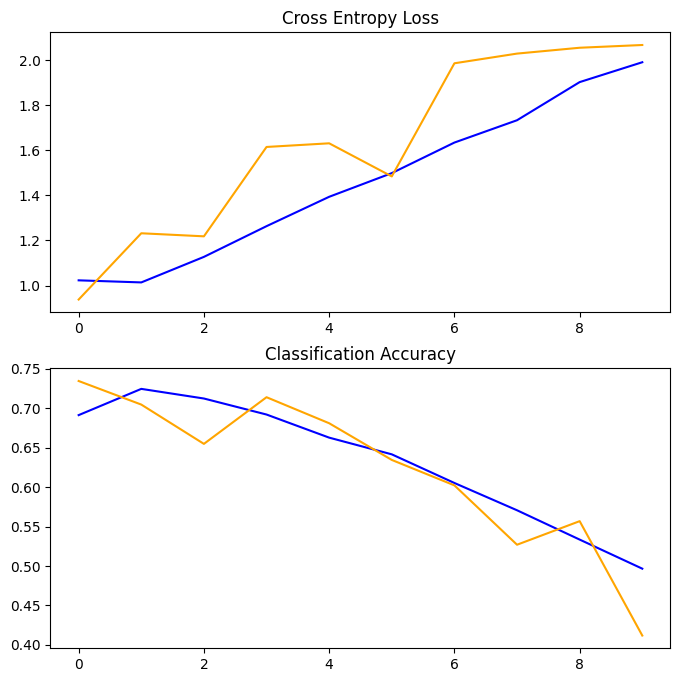

In [83]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple3,epocas=10)
diagnosticos(histories)

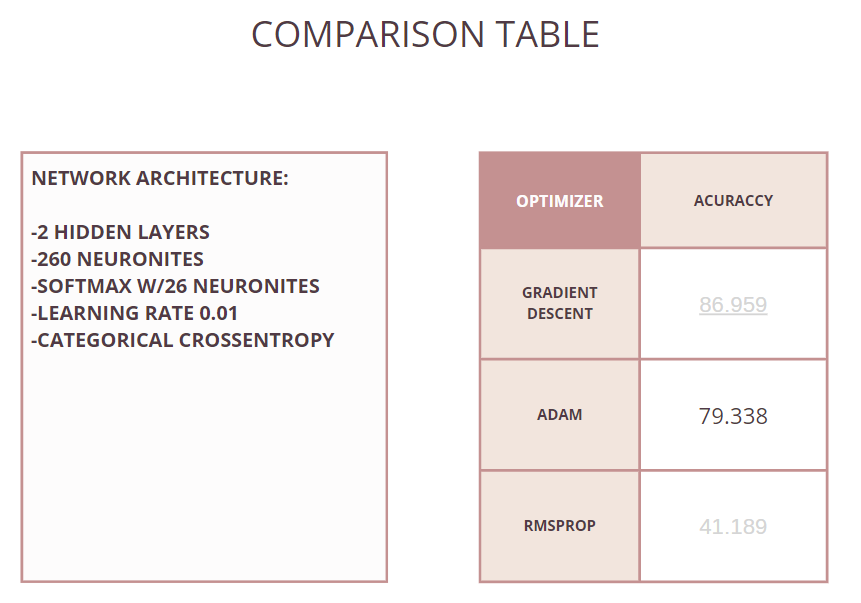

**=====CANTIDAD DE CAPAS=====**

In [85]:
def red_simple_3layer():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(26, activation='softmax'))
  opt = keras.optimizers.SGD(learning_rate=0.01) # Descenso por gradiente.
  model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4172 - loss: 2.0060 - val_accuracy: 0.7505 - val_loss: 0.8232
Epoch 2/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7626 - loss: 0.7535 - val_accuracy: 0.7982 - val_loss: 0.6441
Epoch 3/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8184 - loss: 0.5650 - val_accuracy: 0.8349 - val_loss: 0.5244
Epoch 4/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8516 - loss: 0.4654 - val_accuracy: 0.8323 - val_loss: 0.5126
Epoch 5/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8636 - loss: 0.4199 - val_accuracy: 0.8489 - val_loss: 0.4521
Epoch 6/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.8786 - loss: 0.3718 - val_accuracy: 0.8650 - val_loss: 0.4132
Epoch 7/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8868 - loss: 0.3363 - val_accuracy: 0.8684 - val_loss: 0.3993
Epoch 8/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8985 - loss: 0

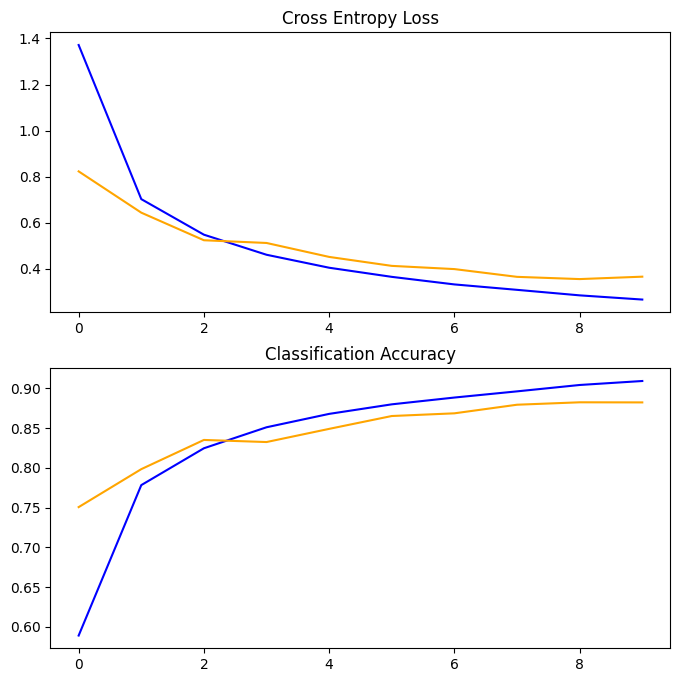

In [86]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple_3layer,epocas=10)
diagnosticos(histories)

In [87]:
def red_simple_10layer():
  model = Sequential() # keras. Agrupa un conjunto de layers dentro de un modelo
  model.add(Flatten()) # Las imágenes son de 28x28, matriciales. Necesitamos achatarlas i.e. 28x28 -> 784 entradas!
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(26, activation='softmax')) # Estamos armando un clasificador... la capa de salida debe ser softmax
  opt = keras.optimizers.SGD(learning_rate=0.01) # Descenso por gradiente. El optimizador más simple
  model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy']) #Compilamos las capas secuenciales.
  #Como es clasificación, nuestra medida de error es entropía cruzada
  #A la vez, queremos que reporte el accuracy
  return model

Epoch 1/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.1450 - loss: 2.7577 - val_accuracy: 0.6422 - val_loss: 1.0981
Epoch 2/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.6834 - loss: 0.9436 - val_accuracy: 0.7177 - val_loss: 0.8295
Epoch 3/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 49s 18ms/step - accuracy: 0.7992 - loss: 0.5960 - val_accuracy: 0.8307 - val_loss: 0.5220
Epoch 4/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.8458 - loss: 0.4567 - val_accuracy: 0.8355 - val_loss: 0.5015
Epoch 5/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.8689 - loss: 0.3882 - val_accuracy: 0.8619 - val_loss: 0.4127
Epoch 6/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.8841 - loss: 0.3378 - val_accuracy: 0.8272 - val_loss: 0.5230
Epoch 7/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.8966 - loss: 0.3014 - val_accuracy: 0.8692 - val_loss: 0.3945
Epoch 8/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.9046 -

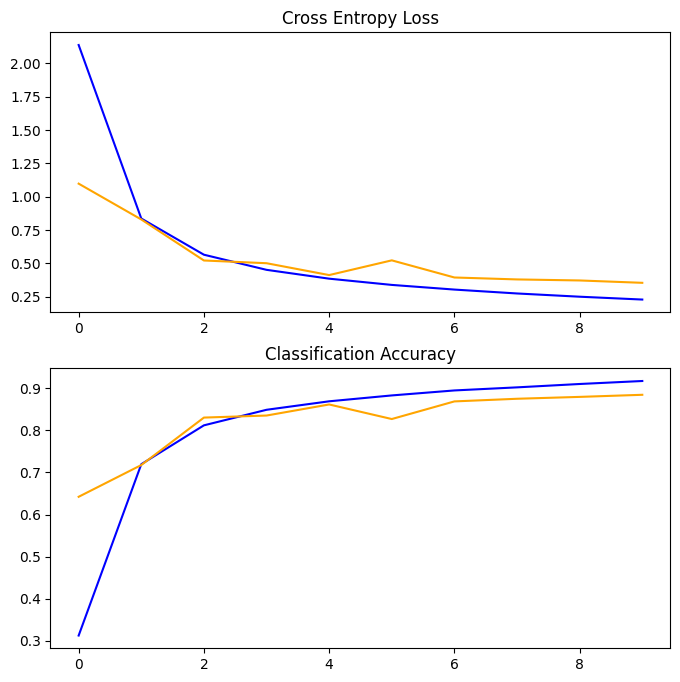

In [89]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple_10layer,epocas=10)
diagnosticos(histories)

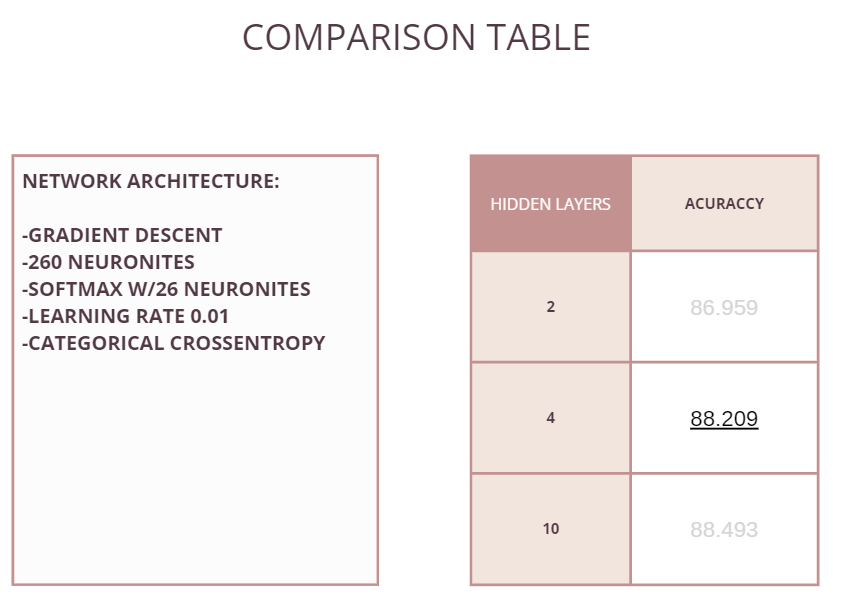

**=====LEARNING RATE=====**

In [90]:
def red_simple_4layer_lr01():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(26, activation='softmax')) #
  opt = keras.optimizers.SGD(learning_rate=0.1) # Descenso por gradiente.
  model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
  #Como es clasificación, nuestra medida de error es entropía cruzada
  return model

Epoch 1/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.6302 - loss: 1.1660 - val_accuracy: 0.8242 - val_loss: 0.4891
Epoch 2/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8606 - loss: 0.4006 - val_accuracy: 0.8730 - val_loss: 0.3811
Epoch 3/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.8936 - loss: 0.3050 - val_accuracy: 0.8626 - val_loss: 0.4310
Epoch 4/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9097 - loss: 0.2499 - val_accuracy: 0.8775 - val_loss: 0.3760
Epoch 5/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9173 - loss: 0.2234 - val_accuracy: 0.8911 - val_loss: 0.3314
Epoch 6/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9275 - loss: 0.1903 - val_accuracy: 0.8963 - val_loss: 0.3204
Epoch 7/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9341 - loss: 0.1734 - val_accuracy: 0.8923 - val_loss: 0.3406
Epoch 8/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9373 - loss: 0

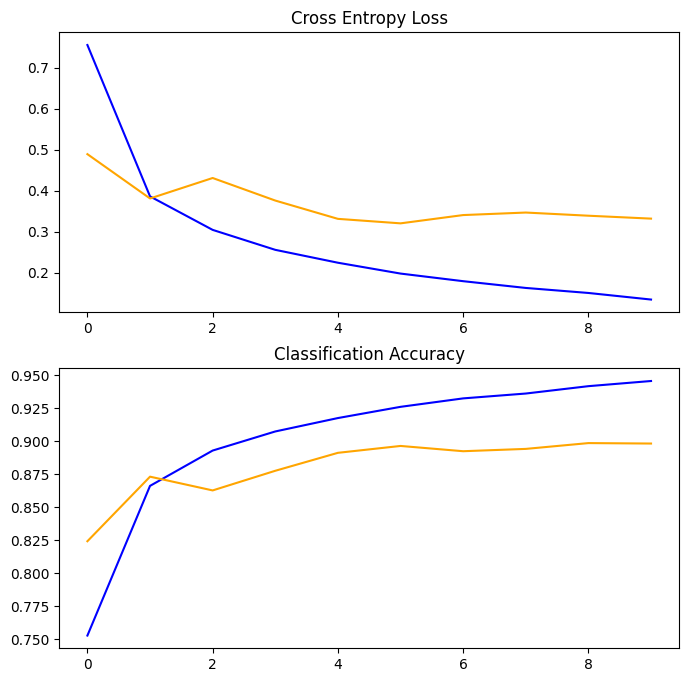

In [91]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple_4layer_lr01,epocas=10)
diagnosticos(histories)

In [93]:
def red_simple_4layer_lr0001():
  model = Sequential() # keras. Agrupa un conjunto de layers dentro de un modelo
  model.add(Flatten()) # Las imágenes son de 28x28, matriciales. Necesitamos achatarlas i.e. 28x28 -> 784 entradas!
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(26, activation='softmax')) # Estamos armando un clasificador... la capa de salida debe ser softmax
  opt = keras.optimizers.SGD(learning_rate=0.001) # Descenso por gradiente. El optimizador más simple
  model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy']) #Compilamos las capas secuenciales.
  #Como es clasificación, nuestra medida de error es entropía cruzada
  #A la vez, queremos que reporte el accuracy
  return model

Epoch 1/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.0816 - loss: 3.1433 - val_accuracy: 0.3676 - val_loss: 2.6576
Epoch 2/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.4278 - loss: 2.4048 - val_accuracy: 0.5330 - val_loss: 1.6788
Epoch 3/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.5624 - loss: 1.5241 - val_accuracy: 0.6051 - val_loss: 1.2893
Epoch 4/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6165 - loss: 1.2313 - val_accuracy: 0.6353 - val_loss: 1.1524
Epoch 5/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.6572 - loss: 1.1066 - val_accuracy: 0.6711 - val_loss: 1.0521
Epoch 6/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6869 - loss: 1.0158 - val_accuracy: 0.6945 - val_loss: 0.9859
Epoch 7/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.7062 - loss: 0.9499 - val_accuracy: 0.7118 - val_loss: 0.9334
Epoch 8/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.7186 - loss: 0

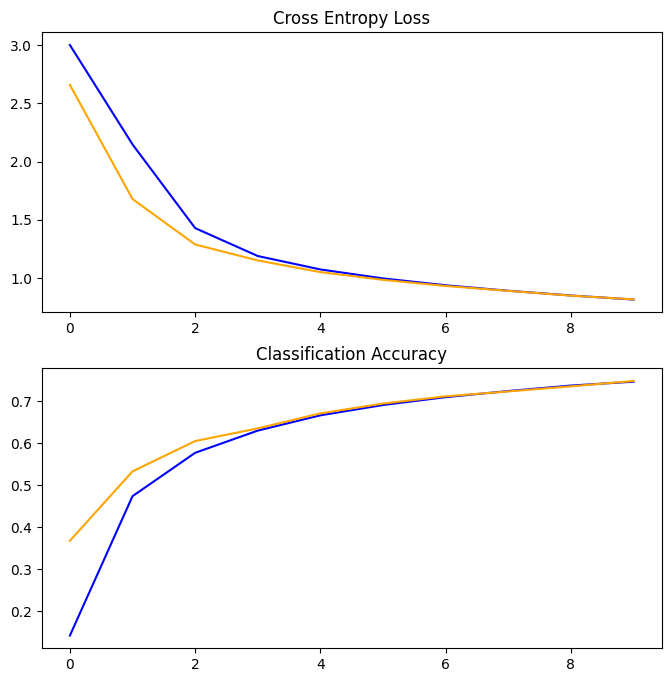

In [94]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple_4layer_lr0001,epocas=10)
diagnosticos(histories)

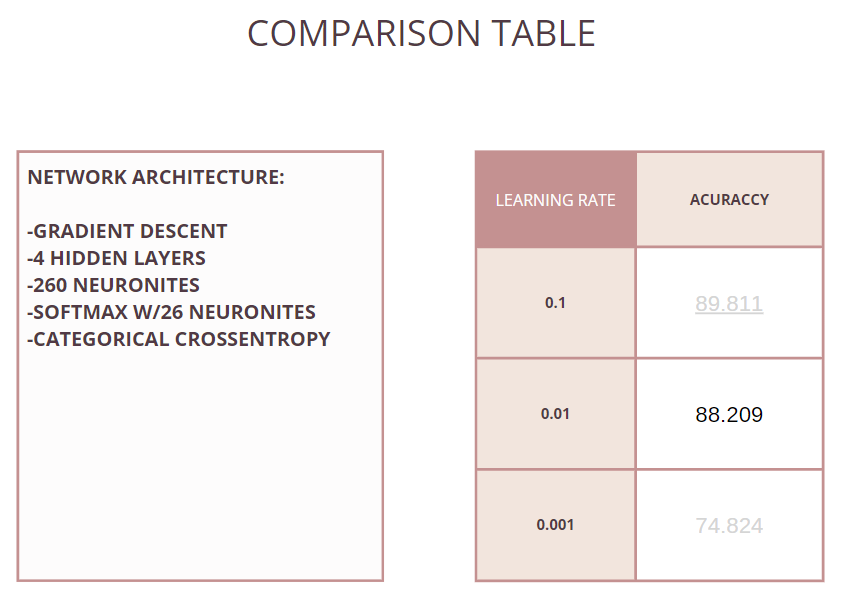

===== **DROP OUT** =====

In [95]:
def red_simple_DROPOUT():
  model = Sequential() # keras. Agrupa un conjunto de layers dentro de un modelo
  model.add(Flatten()) # Las imágenes son de 28x28, matriciales. Necesitamos achatarlas i.e. 28x28 -> 784 entradas!
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dropout(0.01))
  model.add(Dense(26, activation='softmax')) # Estamos armando un clasificador... la capa de salida debe ser softmax
  opt = keras.optimizers.SGD(learning_rate=0.1) # Descenso por gradiente. El optimizador más simple
  model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy']) #Compilamos las capas secuenciales.
  #Como es clasificación, nuestra medida de error es entropía cruzada
  #A la vez, queremos que reporte el accuracy
  return model

Epoch 1/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.6329 - loss: 1.1536 - val_accuracy: 0.8359 - val_loss: 0.4957
Epoch 2/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.8648 - loss: 0.3944 - val_accuracy: 0.8761 - val_loss: 0.3775
Epoch 3/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8918 - loss: 0.3024 - val_accuracy: 0.8785 - val_loss: 0.3646
Epoch 4/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9100 - loss: 0.2492 - val_accuracy: 0.8855 - val_loss: 0.3439
Epoch 5/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9202 - loss: 0.2157 - val_accuracy: 0.8881 - val_loss: 0.3431
Epoch 6/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9291 - loss: 0.1887 - val_accuracy: 0.8953 - val_loss: 0.3278
Epoch 7/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9334 - loss: 0.1725 - val_accuracy: 0.8851 - val_loss: 0.3630
Epoch 8/10
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9370 - loss: 0

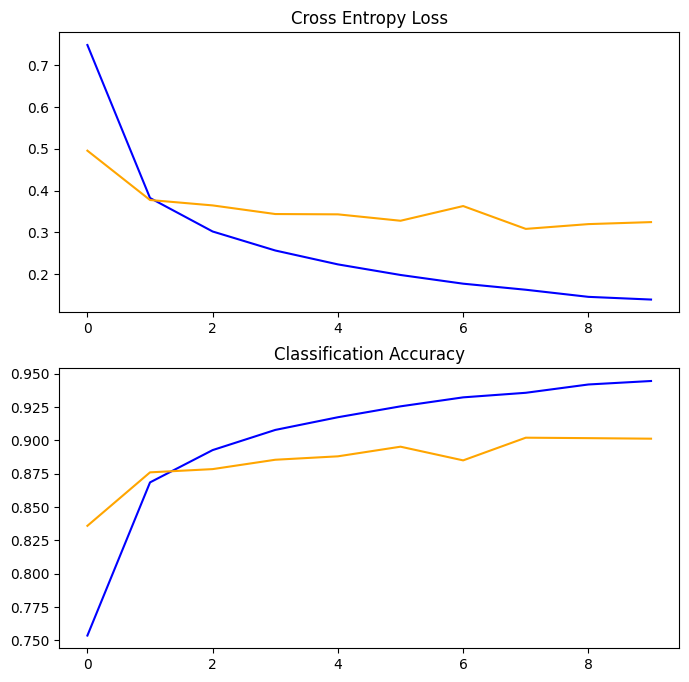

In [96]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple_DROPOUT,epocas=10)
diagnosticos(histories)

In [97]:
def red_simple_FELINA():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(26, activation='softmax'))
  opt = keras.optimizers.SGD(learning_rate=0.1) # Descenso por gradiente.
  model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.6288 - loss: 1.1630 - val_accuracy: 0.8320 - val_loss: 0.4992
Epoch 2/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8634 - loss: 0.3988 - val_accuracy: 0.8505 - val_loss: 0.4413
Epoch 3/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8906 - loss: 0.3131 - val_accuracy: 0.8622 - val_loss: 0.4113
Epoch 4/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9093 - loss: 0.2532 - val_accuracy: 0.8714 - val_loss: 0.3834
Epoch 5/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9192 - loss: 0.2229 - val_accuracy: 0.8926 - val_loss: 0.3211
Epoch 6/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9281 - loss: 0.1923 - val_accuracy: 0.8980 - val_loss: 0.3055
Epoch 7/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9344 - loss: 0.1733 - val_accuracy: 0.8916 - val_loss: 0.3224
Epoch 8/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9379 -

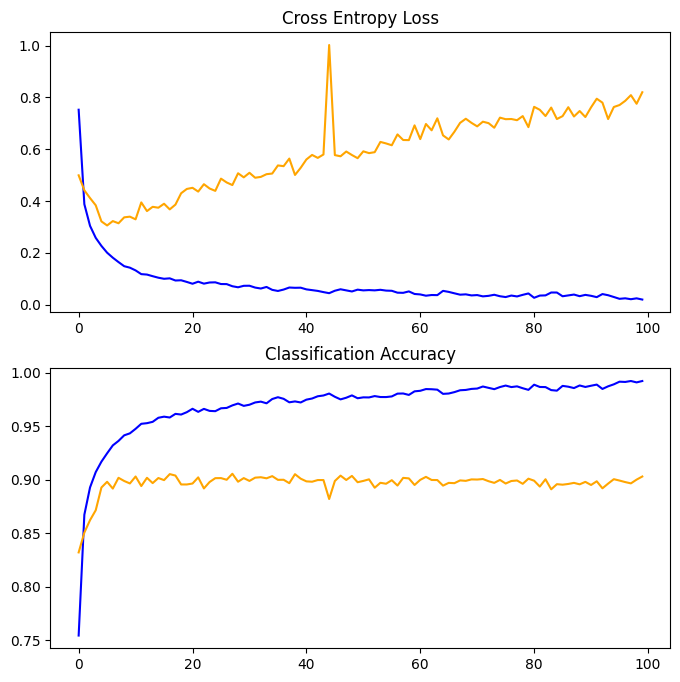

463/463 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


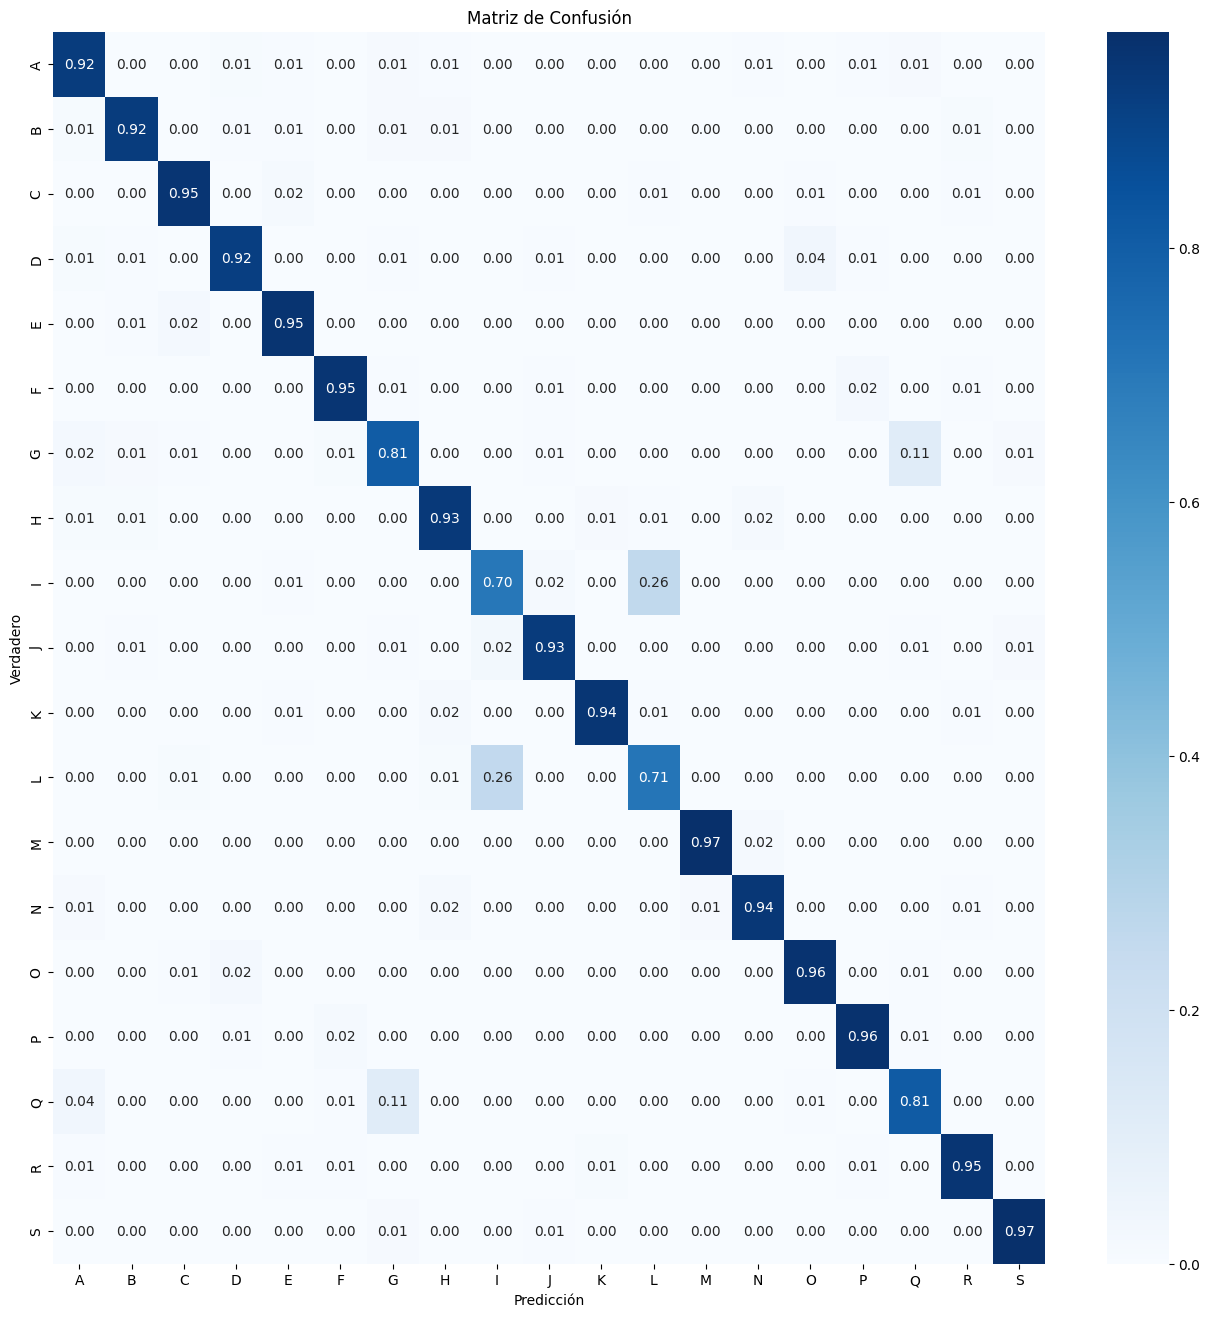

In [98]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple_FELINA,epocas=100)
diagnosticos(histories)
matrizdeconfusion(entrenado,normalizar=True)

In [99]:
def red_simple_FELINA2():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(260, activation="relu")) # Capas ocultas con RELU
  model.add(Dense(26, activation='softmax'))
  opt = keras.optimizers.SGD(learning_rate=0.001) # Descenso por gradiente.
  model.compile(optimizer= opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.0980 - loss: 3.1270 - val_accuracy: 0.3313 - val_loss: 2.6181
Epoch 2/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.4200 - loss: 2.3598 - val_accuracy: 0.5466 - val_loss: 1.6825
Epoch 3/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5684 - loss: 1.5395 - val_accuracy: 0.6098 - val_loss: 1.3023
Epoch 4/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.6287 - loss: 1.2257 - val_accuracy: 0.6482 - val_loss: 1.1325
Epoch 5/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.6666 - loss: 1.0795 - val_accuracy: 0.6825 - val_loss: 1.0308
Epoch 6/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.6921 - loss: 0.9980 - val_accuracy: 0.7037 - val_loss: 0.9640
Epoch 7/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.7157 - loss: 0.9193 - val_accuracy: 0.7167 - val_loss: 0.9158
Epoch 8/100
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7292 -

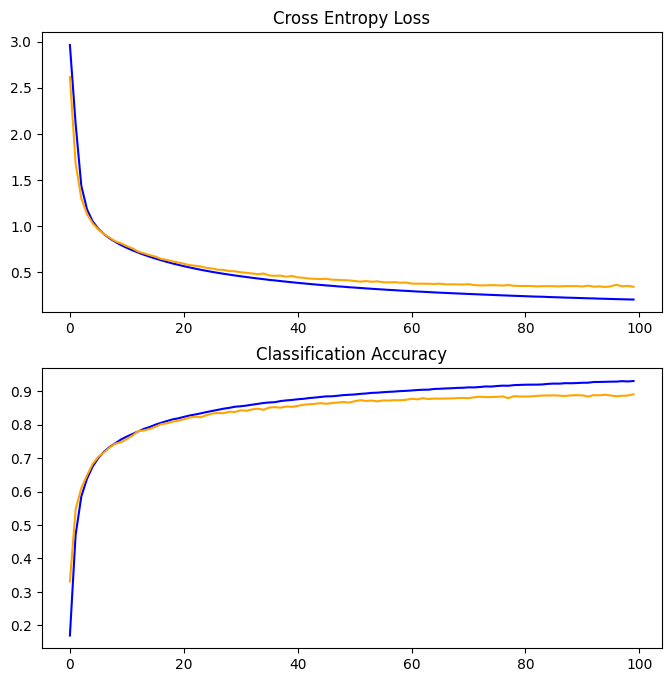

463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


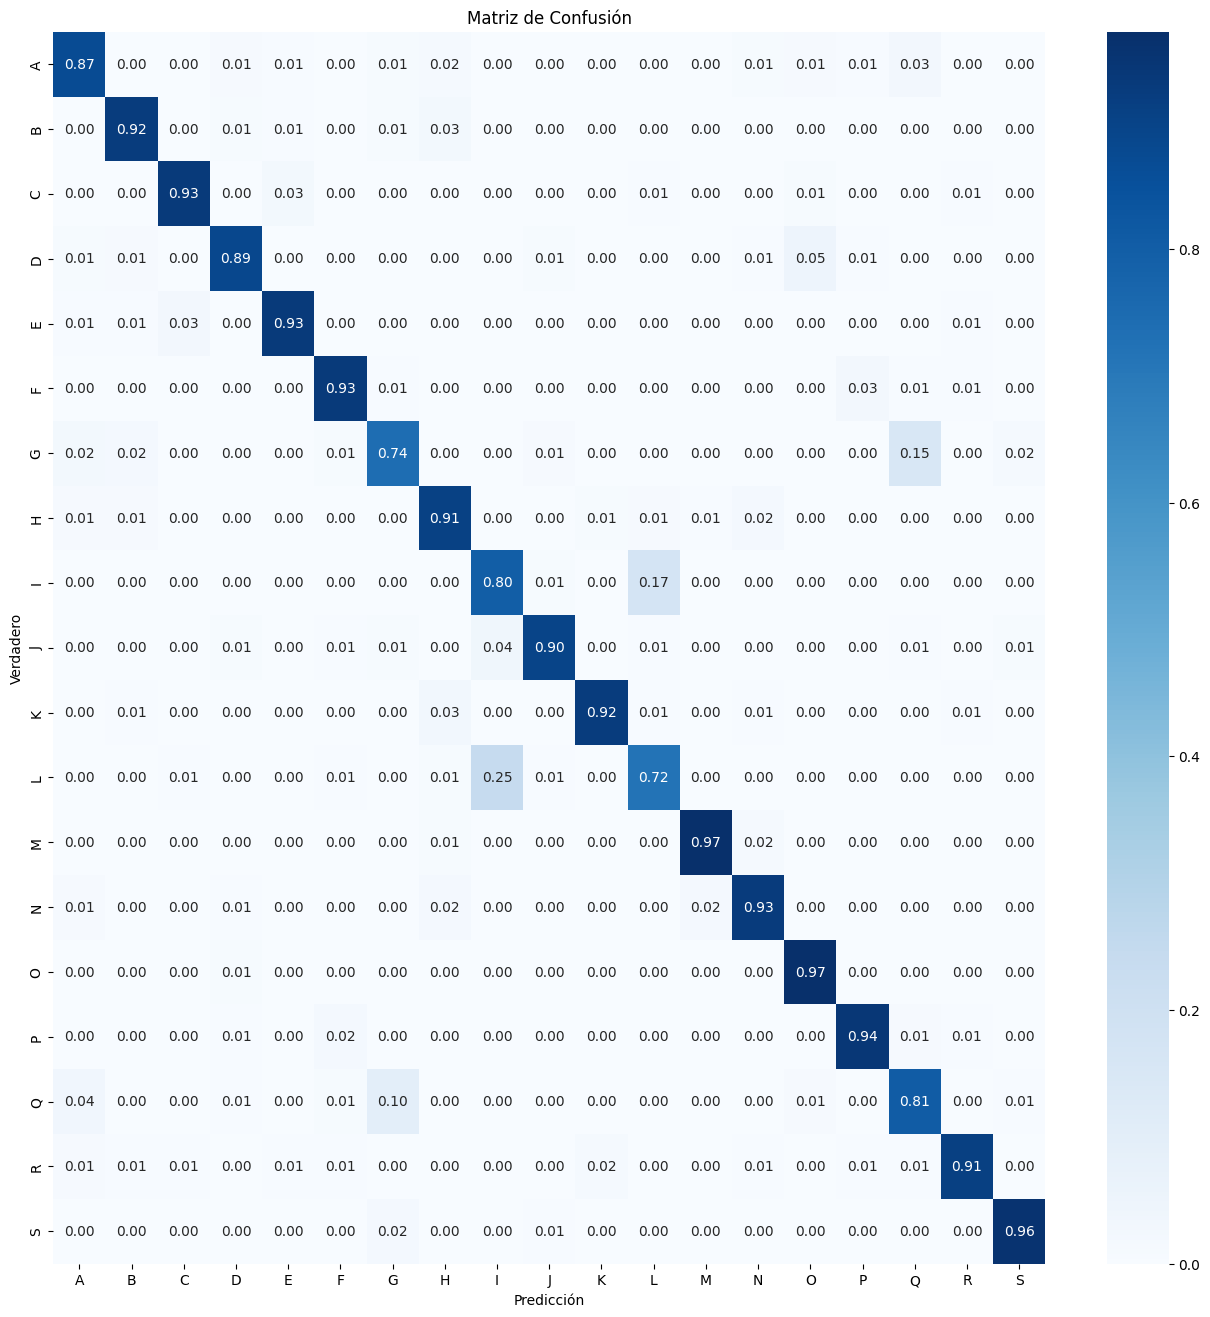

In [100]:
scores, histories, entrenado = evaluar_modelo_simple(trainX, trainY, red_simple_FELINA2,epocas=100)
diagnosticos(histories)
matrizdeconfusion(entrenado,normalizar=True)

In [ ]:
#Por si queremos evaluar post training:
entrenado.evaluate(testX,testY)